Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.32MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 947kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 8.81MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.59MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch 1: loss=0.0142
Epoch 2: loss=0.0049
Epoch 3: loss=0.0039
Epoch 4: loss=0.0035
Epoch 5: loss=0.0033
Epoch 6: loss=0.0032
Epoch 7: loss=0.0031
Epoch 8: loss=0.0031
Epoch 9: loss=0.0030
Epoch 10: loss=0.0030
Epoch 11: loss=0.0029
Epoch 12: loss=0.0029
Epoch 13: loss=0.0029
Epoch 14: loss=0.0029
Epoch 15: loss=0.0028
Epoch 16: loss=0.0028
Epoch 17: loss=0.0028
Epoch 18: loss=0.0028
Epoch 19: loss=0.0028
Epoch 20: loss=0.0027


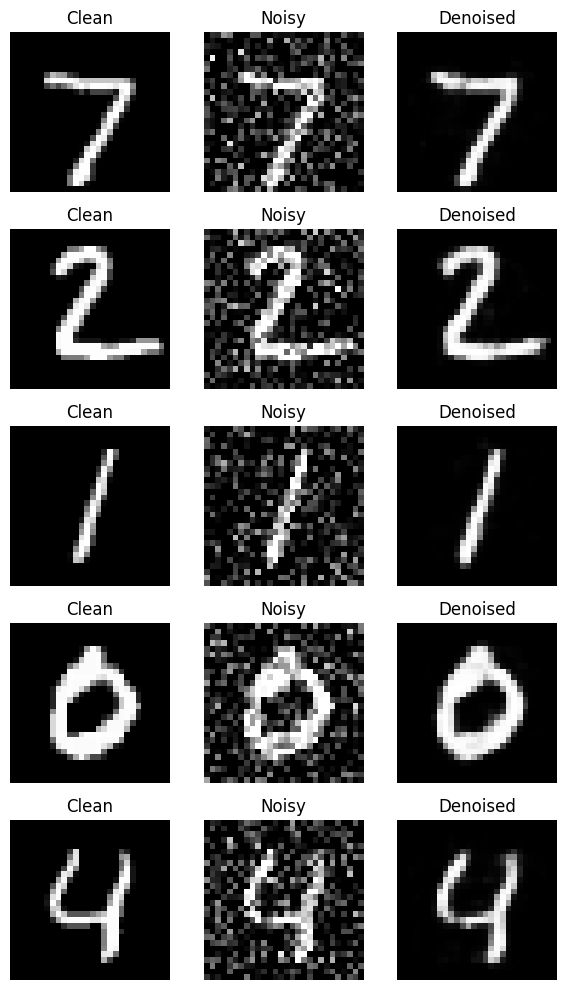

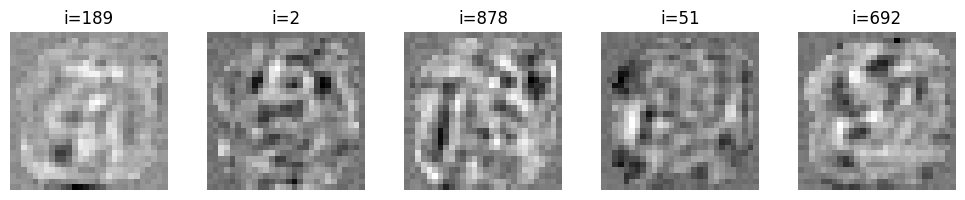

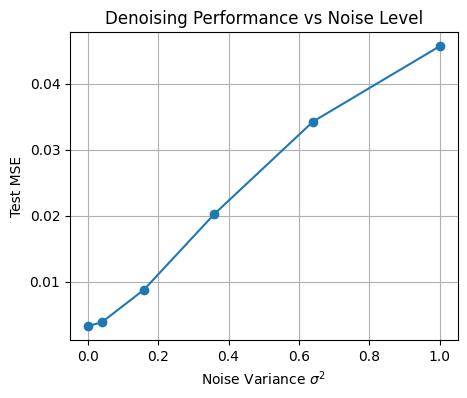

In [ ]:
# ============================================================
# Problem 1: Sparse Encoding for Denoising (ECE685D HW4)
# ============================================================
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -------------------------------
# 1. Dataset & parameters
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)

d = 28 * 28
q = int(1.5 * d)
lambda_l1 = 1e-4
sigma_train = 0.3
epochs = 20

# -------------------------------
# 2. Sparse Denoising Autoencoder
# -------------------------------
class SparseDenoisingAE(nn.Module):
    def __init__(self, f="relu"):
        super().__init__()
        self.encoder = nn.Linear(d, q)
        self.decoder = nn.Linear(q, d, bias=True)
        if f == "relu":
            self.f = nn.ReLU()
        elif f == "tanh":
            self.f = nn.Tanh()
        else:
            self.f = nn.Softplus()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.f(self.encoder(x))
        x_hat = torch.sigmoid(self.decoder(h))
        return x_hat, h

model = SparseDenoisingAE(f="relu").to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -------------------------------
# 3. Training loop
# -------------------------------
for epoch in range(epochs):
    model.train()
    total_loss = 0.
    for x, _ in train_loader:
        x = x.to(device)
        noise = torch.randn_like(x) * sigma_train
        x_noisy = (x + noise).clamp(0., 1.)

        x_hat, h = model(x_noisy)
        mse = 0.5 * ((x_hat - x.view(x.size(0), -1))**2).mean()
        l1 = h.abs().mean()
        loss = mse + lambda_l1 * l1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    print(f"Epoch {epoch+1}: loss={total_loss / len(train_loader.dataset):.4f}")

# -------------------------------
# 4. Visualization (a)
# -------------------------------
model.eval()
x, _ = next(iter(test_loader))
x = x.to(device)
noise = torch.randn_like(x) * sigma_train
x_noisy = (x + noise).clamp(0., 1.)
with torch.no_grad():
    x_hat, h = model(x_noisy)

x = x.cpu()
x_noisy = x_noisy.cpu()
x_hat = x_hat.cpu().view(-1, 1, 28, 28)

fig, axes = plt.subplots(5, 3, figsize=(6, 10))
for i in range(5):
    axes[i,0].imshow(x[i,0], cmap="gray"); axes[i,0].set_title("Clean")
    axes[i,1].imshow(x_noisy[i,0], cmap="gray"); axes[i,1].set_title("Noisy")
    axes[i,2].imshow(x_hat[i,0], cmap="gray"); axes[i,2].set_title("Denoised")
    for j in range(3):
        axes[i,j].axis("off")
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Visualization (b)
# -------------------------------
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    noise = torch.randn_like(x) * sigma_train
    x_noisy = (x + noise).clamp(0., 1.)
    x_hat, h = model(x_noisy)

mean_abs_h = h.abs().mean(dim=0)
topk_vals, topk_idx = torch.topk(mean_abs_h, k=5)
D = model.decoder.weight.data.cpu()
fig, axes = plt.subplots(1, 5, figsize=(10,2))
for k in range(5):
    i = topk_idx[k].item()
    vec = D[:, i].view(28, 28)
    axes[k].imshow(vec, cmap="gray")
    axes[k].set_title(f"i={i}")
    axes[k].axis("off")
plt.tight_layout()
plt.show()

# -------------------------------
# 6. MSE vs noise σ²  (c)
# -------------------------------
sigmas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
mse_list = []
model.eval()

for sigma in sigmas:
    total_mse = 0.
    n = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            noise = torch.randn_like(x) * sigma
            x_noisy = (x + noise).clamp(0., 1.)
            x_hat, _ = model(x_noisy)
            mse = ((x_hat - x.view(x.size(0), -1))**2).mean(dim=1)
            total_mse += mse.sum().item()
            n += x.size(0)
    mse_list.append(total_mse / n)

plt.figure(figsize=(5,4))
plt.plot([s**2 for s in sigmas], mse_list, marker="o")
plt.xlabel(r"Noise Variance $\sigma^2$")
plt.ylabel("Test MSE")
plt.title("Denoising Performance vs Noise Level")
plt.grid(True)
plt.show()


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 242kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.53MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


Training GBRBM with 10 hidden units
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Epoch 20 done
Epoch 21 done
Epoch 22 done
Epoch 23 done
Epoch 24 done
Epoch 25 done
M=10: test MSE=0.0414

Training GBRBM with 50 hidden units
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Epoch 20 done
Epoch 21 done
Epoch 22 done
Epoch 23 done
Epoch 24 done
Epoch 25 done
M=50: test MSE=0.0314

Training GBRBM with 100 hidden units
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 

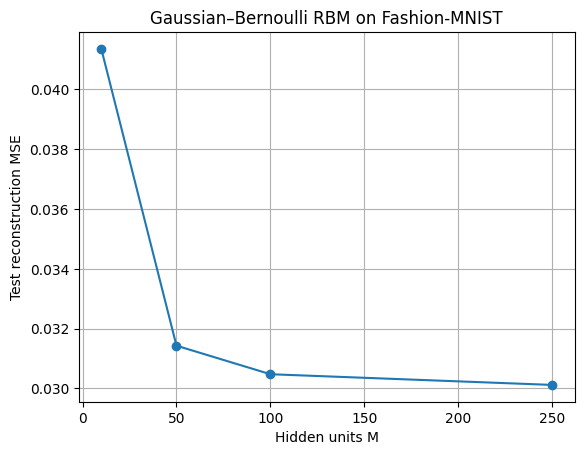

In [2]:
# ======================================================
# Problem 3: Gaussian–Bernoulli RBM on Fashion-MNIST
# ======================================================
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -------------------------------
# 1. Dataset
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
train_ds = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST("./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False)

# -------------------------------
# 2. Gaussian–Bernoulli RBM
# -------------------------------
class GBRBM(nn.Module):
    def __init__(self, n_vis=784, n_hid=100, sigma=1.0):
        super().__init__()
        self.n_vis, self.n_hid, self.sigma = n_vis, n_hid, sigma
        self.W = nn.Parameter(torch.randn(n_vis, n_hid) * 0.01)
        self.b = nn.Parameter(torch.zeros(n_vis))  # visible bias
        self.a = nn.Parameter(torch.zeros(n_hid))  # hidden bias

    def sample_h(self, v):
        p_h = torch.sigmoid((v / self.sigma) @ self.W + self.a)
        return p_h, torch.bernoulli(p_h)

    def sample_v(self, h):
        mean_v = self.b + self.sigma * (h @ self.W.T)
        v = mean_v + self.sigma * torch.randn_like(mean_v)
        return mean_v, v

def train_gbrbm(n_hid, n_epochs=25, lr=1e-3, sigma=1.0, device="cuda"):
    rbm = GBRBM(784, n_hid, sigma).to(device)
    opt = torch.optim.Adam(rbm.parameters(), lr=lr)
    for epoch in range(n_epochs):
        for v0,_ in train_loader:
            v0 = v0.to(device)
            ph0, h0 = rbm.sample_h(v0)
            mean_v1, v1 = rbm.sample_v(h0)
            ph1, h1 = rbm.sample_h(v1)

            dW = (v0.T @ ph0 - v1.T @ ph1) / v0.size(0)
            db = (v0 - v1).mean(0)
            da = (ph0 - ph1).mean(0)
            rbm.W.grad = -dW
            rbm.b.grad = -db
            rbm.a.grad = -da
            opt.step(); opt.zero_grad()
        print(f"Epoch {epoch+1} done")
    # test MSE
    rbm.eval()
    mse = 0; n=0
    with torch.no_grad():
        for v,_ in test_loader:
            v=v.to(device)
            _,h = rbm.sample_h(v)
            mean_v,_ = rbm.sample_v(h)
            mse += ((mean_v-v)**2).sum().item()
            n += v.numel()
    return mse/n

# -------------------------------
# 3. Run for different hidden sizes
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_list = [10, 50, 100, 250]
results = {}
for M in hidden_list:
    print(f"\nTraining GBRBM with {M} hidden units")
    results[M] = train_gbrbm(M, device=device)
    print(f"M={M}: test MSE={results[M]:.4f}")

plt.plot(list(results.keys()), list(results.values()), marker="o")
plt.xlabel("Hidden units M")
plt.ylabel("Test reconstruction MSE")
plt.title("Gaussian–Bernoulli RBM on Fashion-MNIST")
plt.grid(True)
plt.show()
